 # PAOO5: High Value Customer Identification (Insiders)

## Planejamento da solução (IoT)

### Input

1. Problema de negocio
    * selecionar os clientes mais valiosos para integrar um programa de fidelizacao.
2. Conjunto de dados
    * Vendas de um e-commerce online, durante o periodo de um ano.

### Output

1. A indicacao das pessoas que farao parte do programa de Insiders
    - Lista: client_id|is_insider


2. Relatorio com as respostas das perguntas de negocio
- Quem sao as pessoas elegiveis para participar do programa insiders ?
    1. **Who are the people eligible to participate in the Insiders program?**
    2. **How many customers will be part of the group?**
    3. **What are the main characteristics of these customers?**
    4. **What percentage of revenue contribution comes from Insiders?**
    5. **What is this group's expected revenue for the coming months?**
    6. **What are the conditions for a person to be eligible for Insiders?**
    7. **What are the conditions for a person to be removed from Insiders?**
    8. **What is the guarantee that the Insiders program is better than the rest of the base?**
    9. **What actions can the marketing team take to increase revenue?**

### Tasks

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0 IMPORTS

In [1]:
# %pip install plotly

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML
import inflection
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn import metrics as m
from plotly import express as px
import umap.umap_ as umap

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loadind dataset

In [4]:
df_raw=pd.read_csv('/home/tc0019/DS/insiders_cluster/dataset/Ecommerce.csv', encoding='unicode_escape')
df_raw=df_raw.drop( columns = ['Unnamed: 8'], axis=1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descricao dos dados

In [5]:
df1=df_raw.copy()

## 1.1 Rename columns

In [6]:
cols_old=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

df1.columns=cols_new

df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
92150,544178,22207,FRYING PAN UNION FLAG,64,14-Feb-17,4.25,14543.0,United Kingdom


## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 1.3. Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4.1 Remove NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.25


In [11]:
df1.isna().sum()


invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [12]:
df1.shape

(406829, 8)

## 1.5. Descriptive Statistics

### 1.5.1. Numerical Atributes

## 1.6 Change dtypes

In [13]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')


# 2.0 Feature Engineering

In [14]:
df2=df1.copy()

In [15]:
# data reference
df_ref=df2.drop(['invoice_no', 'stock_code', 'description',
         'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [16]:
# Gross revenue (quantity * price)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary 
df_monetary=df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref=pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - last day purchase
df_recency=df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency=df_recency[['customer_id','recency_days']].groupby('customer_id').sum().reset_index()
df_ref=pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq=df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref=pd.merge(df_ref,df_freq, on='customer_id', how='left')
df_ref.isna().sum()

# AVG ticket

df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')

In [17]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850.0,5288.63,302,35,16.950737
1,13047.0,3079.10,31,18,15.709694
2,12583.0,7187.34,2,18,28.634821
3,13748.0,948.25,95,5,33.866071
4,15100.0,635.10,330,6,105.850000


# 3.0 Filtragem de variaveis

In [18]:
df3=df_ref.copy()

# 4.0 EDA

In [19]:
df4=df3.copy()


# 5.0 Data preparation

In [20]:
df5=df4.copy()


# 6.0 Feature Selection

In [21]:
df6=df5.copy()


# 7.0 Hyperparameter fine tuning

In [22]:
df7=df6.copy()
X = df6.drop(columns='customer_id')
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

Text(0.5, 1.0, 'WSS vs K')

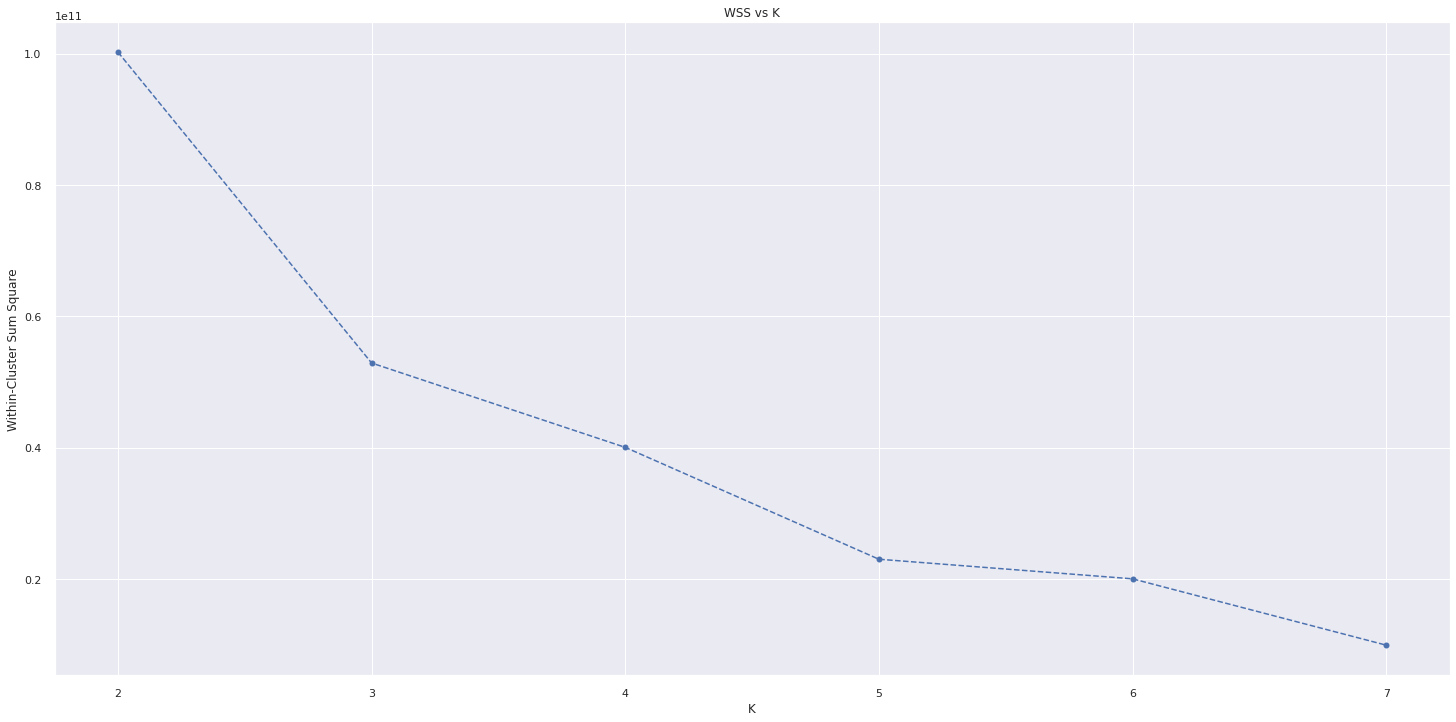

In [23]:
wss = []
for k in clusters:
    # model definition
    kmeans=c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model Training
    kmeans.fit(X)

    # validation
    wss.append( kmeans.inertia_)

# plot wss elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum Square');
plt.title('WSS vs K')

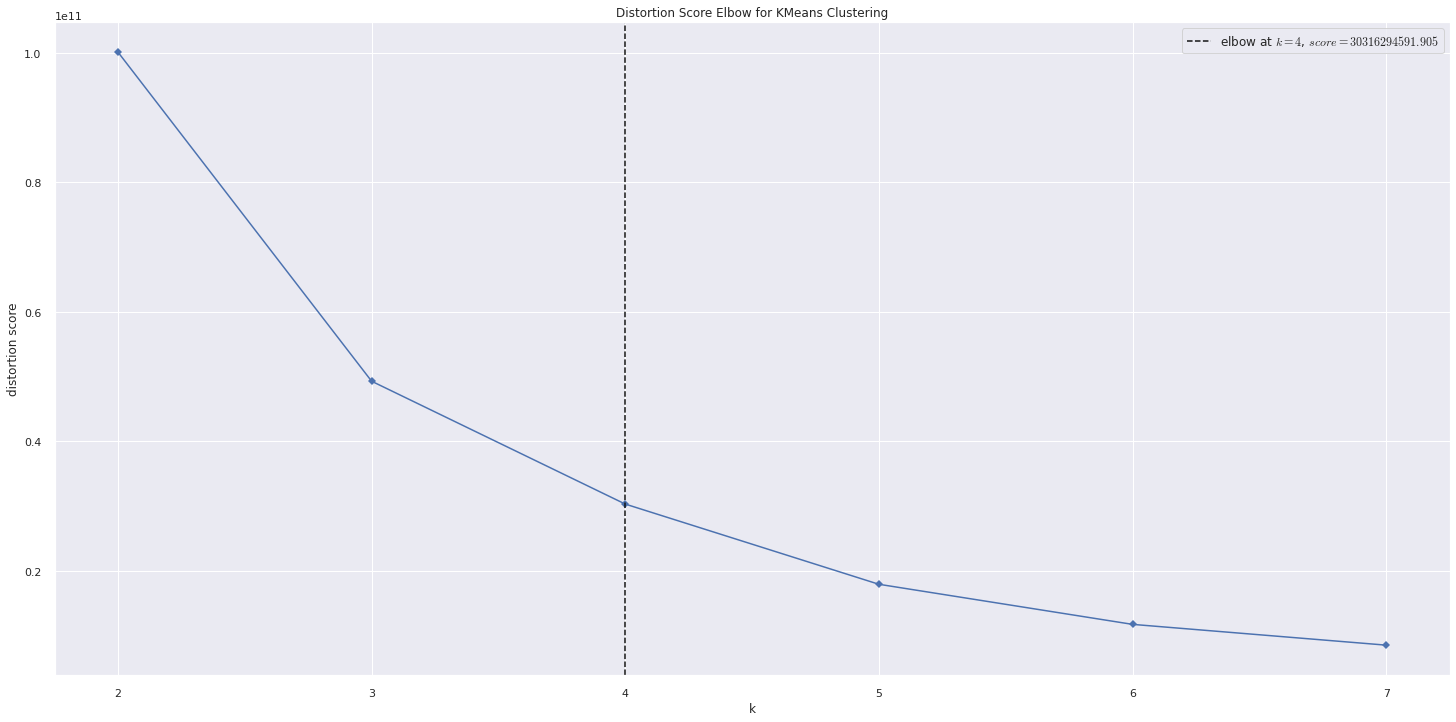

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show()

## 7.2 Sillhouette Score

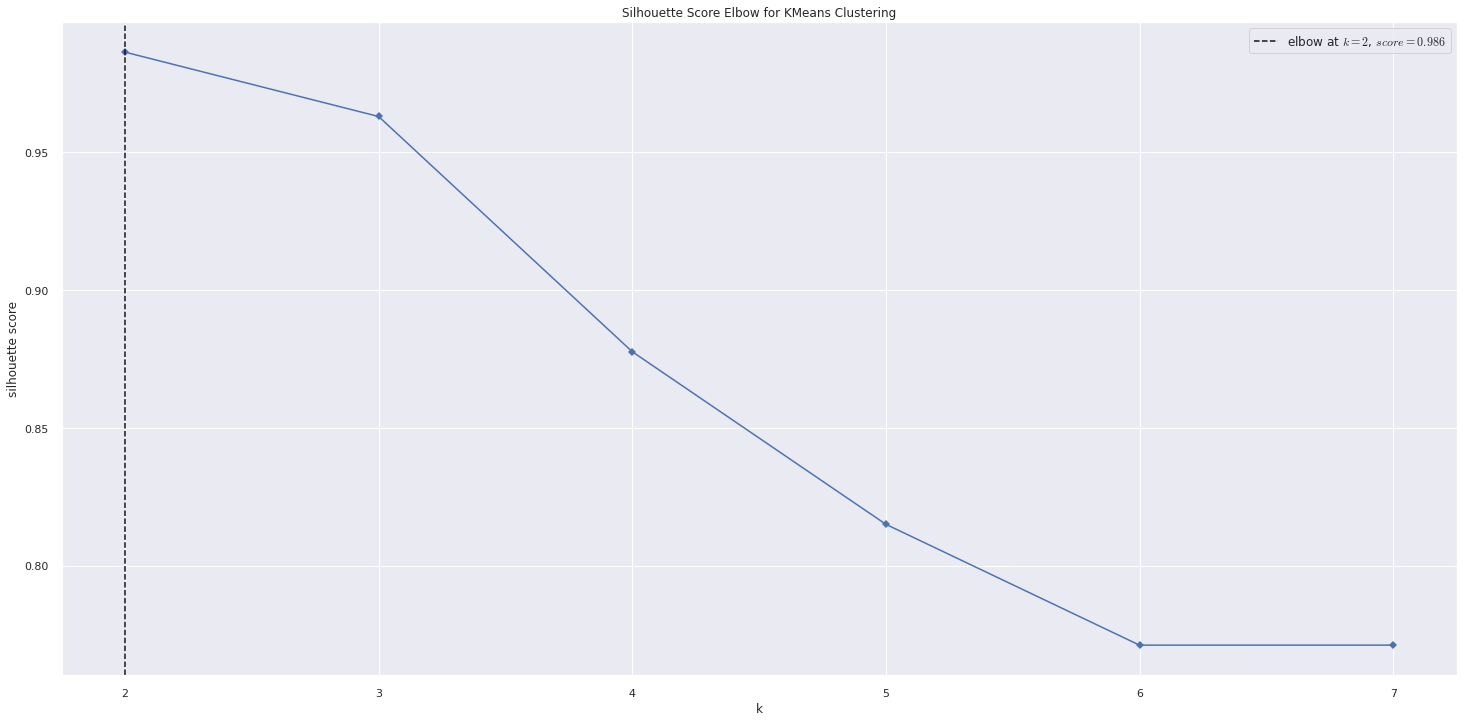

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [25]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show()

## 7.3 Silhouette Analysis

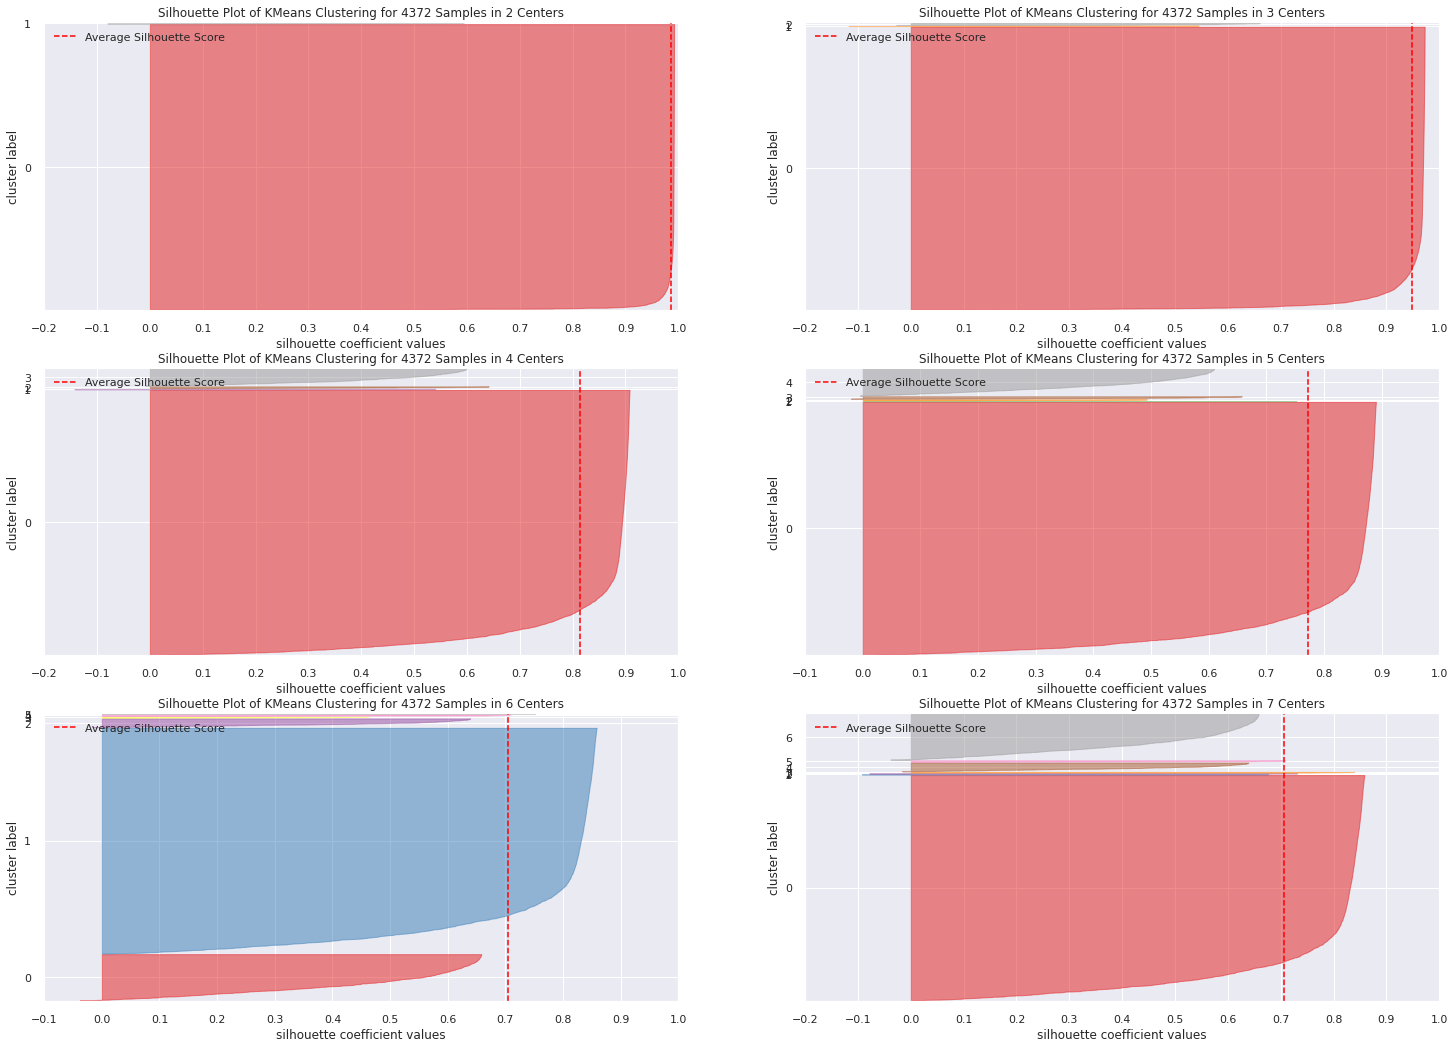

In [26]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18))


for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

In [27]:
df8=df7.copy()


## 8.1 K-Means

In [28]:
# model definition
k=4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)


# model training
kmeans.fit(X)


# clustering
labels=kmeans.labels_

## 8.2 Cluster Validation

In [29]:
## WSS (within -cluster sum of squares)
print ('WSS Value: {}'.format(kmeans.inertia_))

## SS (silhouette score)
print ('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value: 40056506734.602486
SS Value: 0.8139972028952444


# 9.0 Cluster Analysis

In [30]:
df9=df8.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850.0,5288.63,302,35,16.950737,3
1,13047.0,3079.10,31,18,15.709694,0
2,12583.0,7187.34,2,18,28.634821,3
3,13748.0,948.25,95,5,33.866071,0
4,15100.0,635.10,330,6,105.850000,0


## 9.1 Visualization Inspections

In [31]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbricks')

### 9.1.1 2D Plot

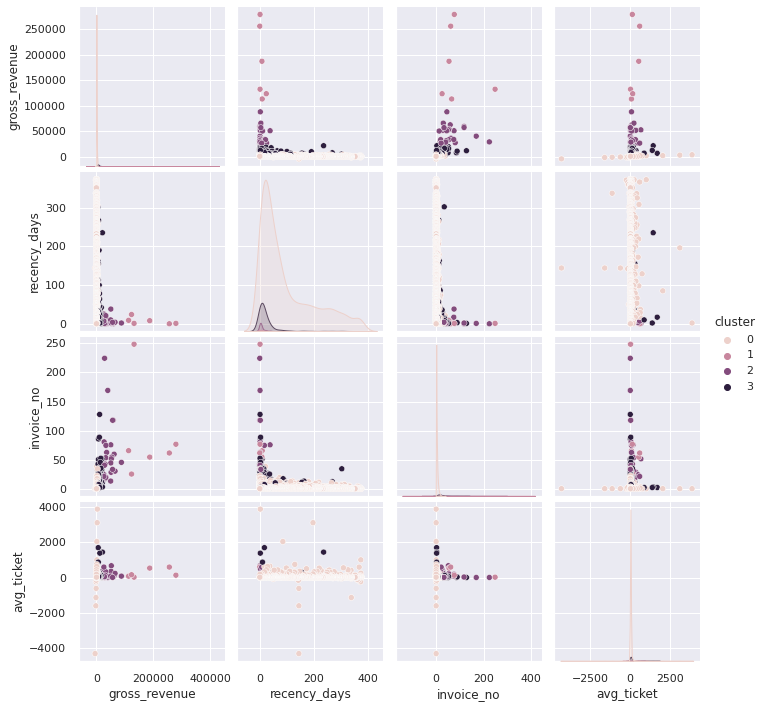

In [32]:
df_viz= df9.drop(columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster')

In [33]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 Cluster Profile

In [34]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster 

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

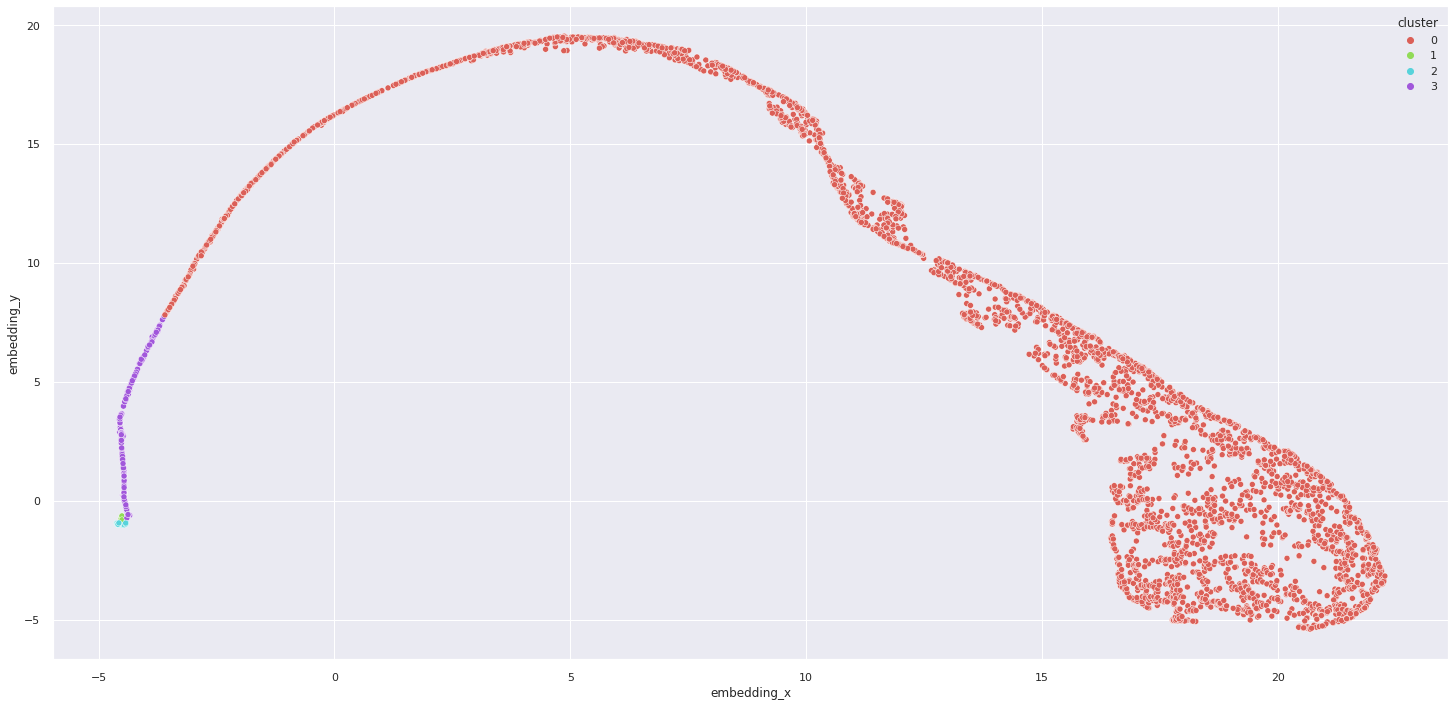

In [35]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.71% do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# 10.0 Deploy to production

In [36]:
df10=df9.copy()
